# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Объявление необходмых библиотек, загрузка датафреймов и вывод их основной информации:

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error

from scipy import stats as st

In [2]:
def directory(pth):
    if os.path.exists(pth[0]):
        query = pd.read_csv(pth[0], index_col=0)
    elif os.path.exists(pth[1]):
        query = pd.read_csv(pth[1], index_col=0)
    else:
        query = 'Ошибка! Файл не найден.'
    return query

pth1 = ['https://code.s3.yandex.net/datasets/geo_data_0.csv', '/datasets/geo_data_0.csv']
pth2 = ['https://code.s3.yandex.net/datasets/geo_data_1.csv', '/datasets/geo_data_1.csv']
pth3 = ['https://code.s3.yandex.net/datasets/geo_data_2.csv', '/datasets/geo_data_2.csv']
 
df1 = directory(pth1)
display(df1)
display(df1.info())

df2 = directory(pth2)
display(df2)
display(df2.info())

df3 = directory(pth3)
display(df3)
display(df3.info())

,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497823,1.221170,105.280062
2acmU,1.334711,-0.340164,4.365080,73.037750
409Wp,1.022732,0.151990,1.419926,85.265647
iJLyR,-0.032172,0.139033,2.978566,168.620776
Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...
DLsed,0.971957,0.370953,6.075346,110.744026
QKivN,1.392429,-0.382606,1.273912,122.346843
3rnvd,1.029585,0.018787,-1.348308,64.375443


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
id,,,,
kBEdx,-15.001348,-8.276000,-0.005876,3.179103
62mP7,14.272088,-3.475083,0.999183,26.953261
vyE1P,6.263187,-5.948386,5.001160,134.766305
KcrkZ,-13.081196,-11.506057,4.999415,137.945408
AHL4O,12.702195,-8.147433,5.004363,134.766305
...,...,...,...,...
QywKC,9.535637,-6.878139,1.998296,53.906522
ptvty,-10.160631,-12.558096,5.005581,137.945408
09gWa,-7.378891,-3.084104,4.998651,137.945408


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, kBEdx to relB0
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
id,,,,
fwXo0,-1.146987,0.963328,-0.828965,27.758673
WJtFt,0.262778,0.269839,-2.530187,56.069697
ovLUW,0.194587,0.289035,-5.586433,62.871910
q6cA6,2.236060,-0.553760,0.930038,114.572842
WPMUX,-0.515993,1.716266,5.899011,149.600746
...,...,...,...,...
4GxBu,-1.777037,1.125220,6.263374,172.327046
YKFjq,-1.261523,-0.894828,2.524545,138.748846
tKPY3,-1.199934,-2.957637,5.219411,157.080080


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, fwXo0 to V9kWn
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


None

### Предобработка данных

Предобработка исходным датафреймам не требуется: данные не имеют пропусков, дубликатов, неявных дубликатов.

### Исследовательский анализ данных

Проведём исследовательский анализ данных из каждой таблицы.

#### Первый датафрейм:

Изучим параметры первого датафрейма. Необходимо проверить данные на наличие аномалий и выбросов. Построим гистограммы распределения количественных признаков.

,f0
count,100000.00
mean,0.50
median,0.50
max,2.36
min,-1.41


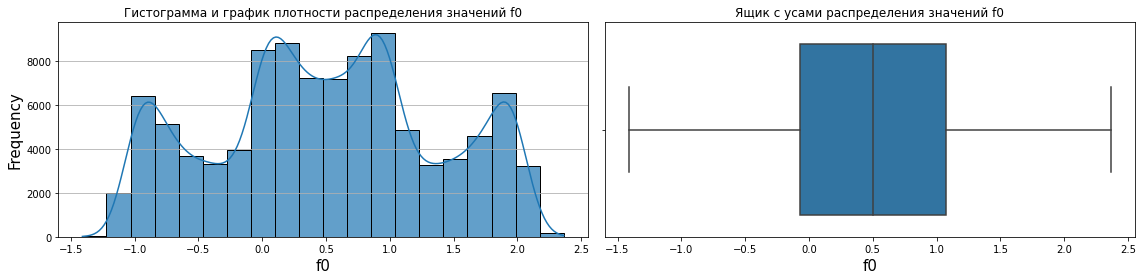

,f1
count,100000.00
mean,0.25
median,0.25
max,1.34
min,-0.85


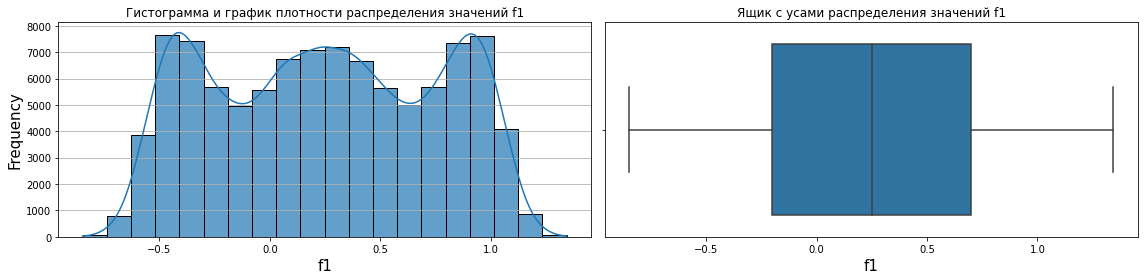

,f2
count,100000.00
mean,2.50
median,2.52
max,16.00
min,-12.09


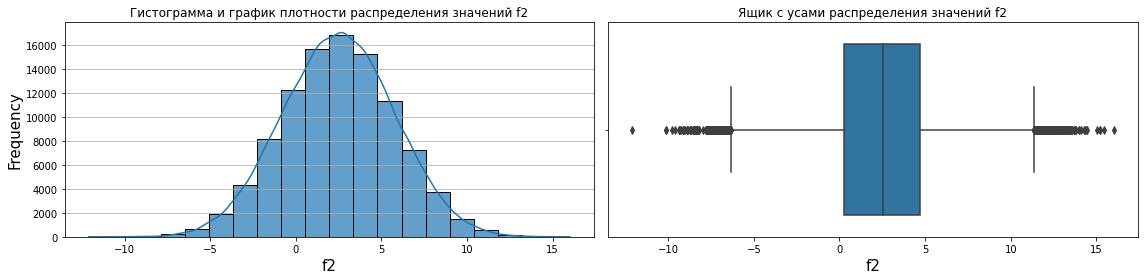

,product
count,100000.00
mean,92.50
median,91.85
max,185.36
min,0.00


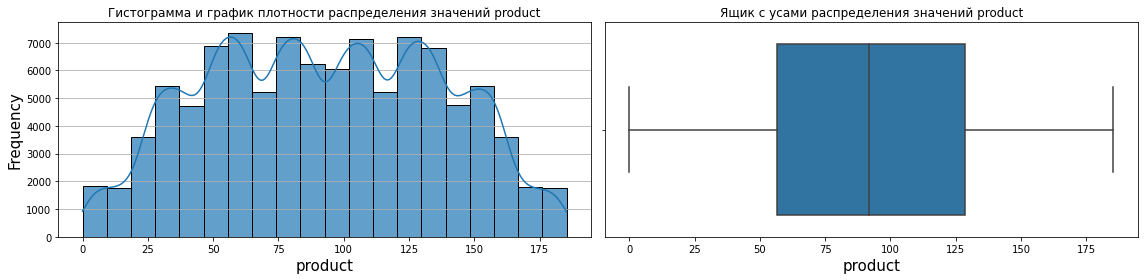

In [3]:
def histogram(data):

    rows = data.select_dtypes(include=['float64', 'int64']).columns
    for i, col in enumerate(rows):
        if col != 'id' and data[col].nunique() > 10:
            f, ax = plt.subplots(1, 2, figsize=(16, 4))
            display(round(data[col].agg(['count', 'mean', 'median', 'max', 'min']), 2).to_frame())
            sns.histplot(x=data[col], kde=True, bins=20, multiple='stack', ax = ax[0], alpha=0.7)
            sns.boxplot(x=data[col], ax = ax[1])
            ax[0].set_title('Гистограмма и график плотности распределения значений {}'.format(col))
            ax[0].set_xlabel(col, fontsize=15)
            ax[0].set_ylabel('Frequency', fontsize=15)          
            ax[0].grid(axis='y')
            ax[1].set_title('Ящик с усами распределения значений {}'.format(col))
            ax[1].set_xlabel(col, fontsize=15)
            plt.tight_layout()
            plt.show()
        elif col != 'id':
            display(round(data[col].agg(['count', 'mean', 'median', 'max', 'min']), 2).to_frame())
            sns.countplot(x=data[col])
            plt.grid(axis='y')
            plt.gca().set_axisbelow(True)
            plt.title('Распределение категорий в столбце {}'.format(col))
            plt.tight_layout()
            plt.show()
                

    for col in data.select_dtypes(include='object').columns:
        plt.pie(x=data[col].value_counts(), labels = data[col].value_counts().index, autopct='%1.1f%%')
        plt.title('Диаграмма значений столбца {}'.format(col))
        plt.show()


histogram(df1)

Нормальное распределение наблюдается у параметра `f2`. По остальным параметрам также можно проследить нормальное распределение, но с несколькими локальными "пиками" данных.

#### Второй датафрейм:

,f0
count,100000.00
mean,1.14
median,1.15
max,29.42
min,-31.61


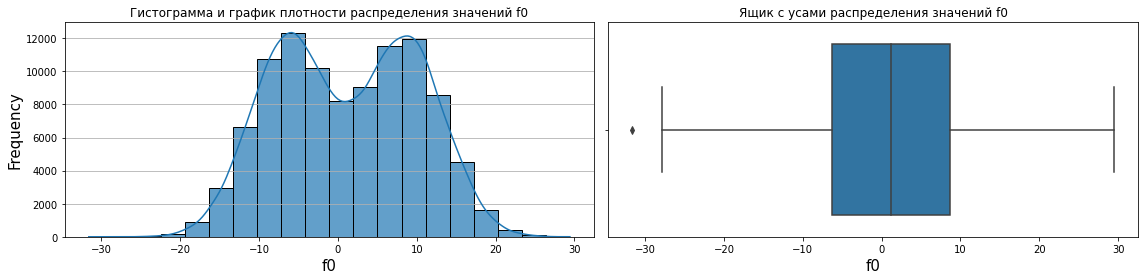

,f1
count,100000.00
mean,-4.80
median,-4.81
max,18.73
min,-26.36


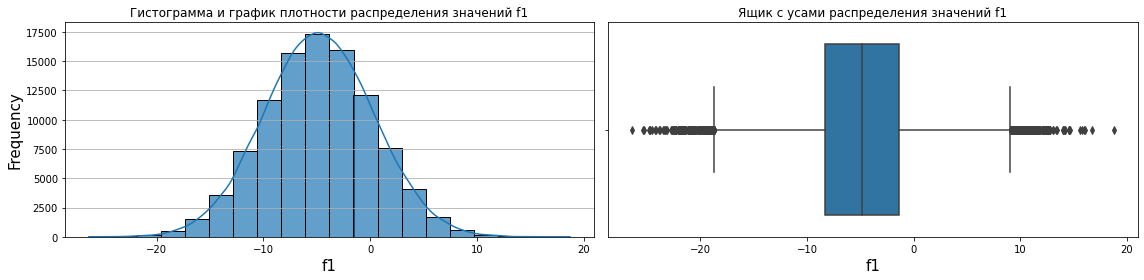

,f2
count,100000.00
mean,2.49
median,2.01
max,5.02
min,-0.02


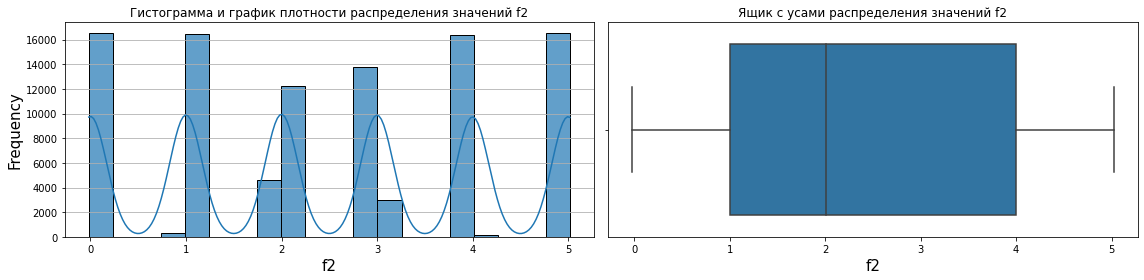

,product
count,100000.00
mean,68.83
median,57.09
max,137.95
min,0.00


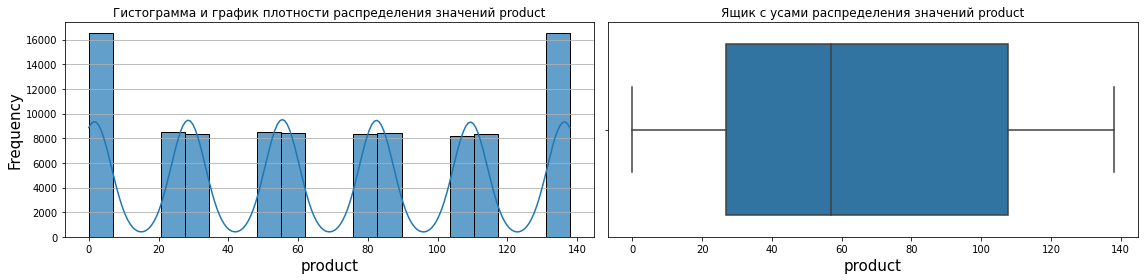

In [4]:
histogram(df2)

Нормальное распределение наблюдается у параметра `f1`. По параметру `f0` также можно проследить нормальное распределение, но с несколькими локальными "пиками" данных. Параметры `f2` и `product` имеют "градацию" (практически все значения собраны в окрестности какого-либо значения, наблюдается интервальность). 

#### Третий датафрейм:

,f0
count,100000.00
mean,0.00
median,0.01
max,7.24
min,-8.76


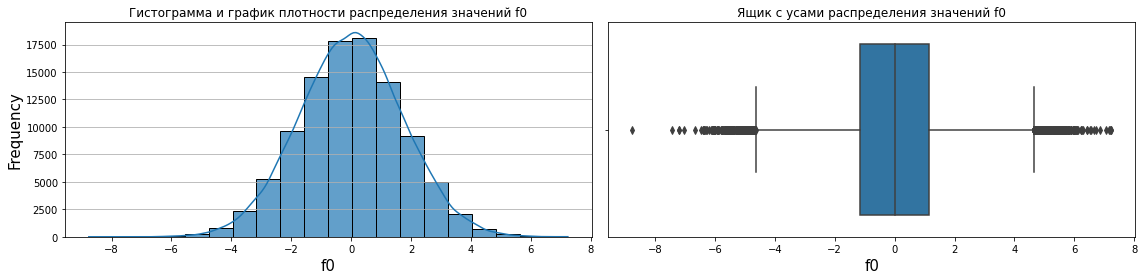

,f1
count,100000.00
mean,-0.00
median,-0.01
max,7.84
min,-7.08


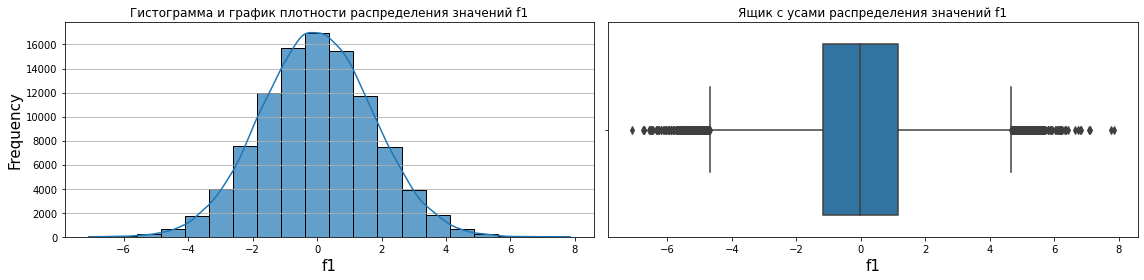

,f2
count,100000.00
mean,2.50
median,2.48
max,16.74
min,-11.97


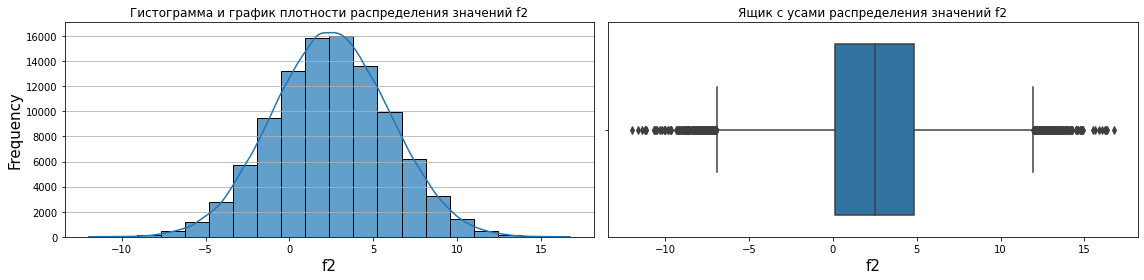

,product
count,100000.00
mean,95.00
median,94.93
max,190.03
min,0.00


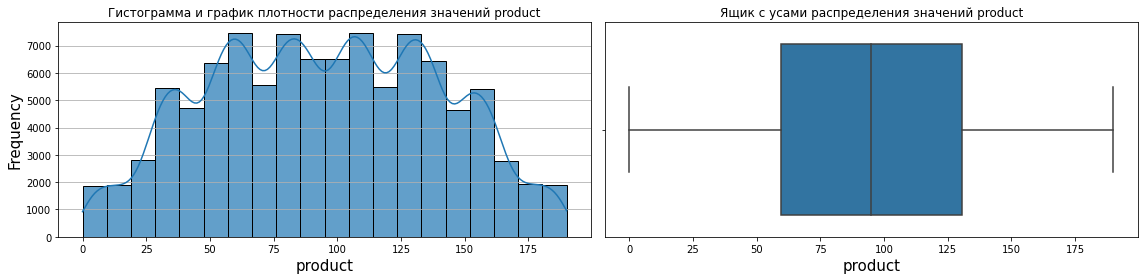

In [5]:
histogram(df3)

У параметра `product` можно проследить нормальное распределение, но с несколькими локальными "пиками" данных.  По остальным параметрам наблюдается нормальное распределение.

#### Промежуточный вывод:

* первый датафрейм: нормальное распределение наблюдается у параметра `f2`. По остальным параметрам также можно проследить нормальное распределение, но с несколькими локальными "пиками" данных;

* второй датафрейм: нормальное распределение наблюдается у параметра `f1`. По параметру `f0` также можно проследить нормальное распределение, но с несколькими локальными "пиками" данных. Параметры `f2` и `product` имеют "градацию" (практически все значения собраны в окрестности какого-либо значения, наблюдается интервальность);

* третий датафрейм: у параметра `product` можно проследить нормальное распределение, но с несколькими локальными "пиками" данных.  По остальным параметрам наблюдается нормальное распределение.


### Корреляционный анализ

Проведём корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования и сделаем выводы о мультиколлинеарности и утечке данных.

#### Первый датафрейм:

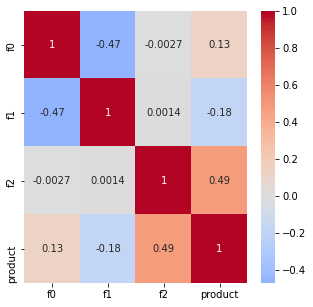

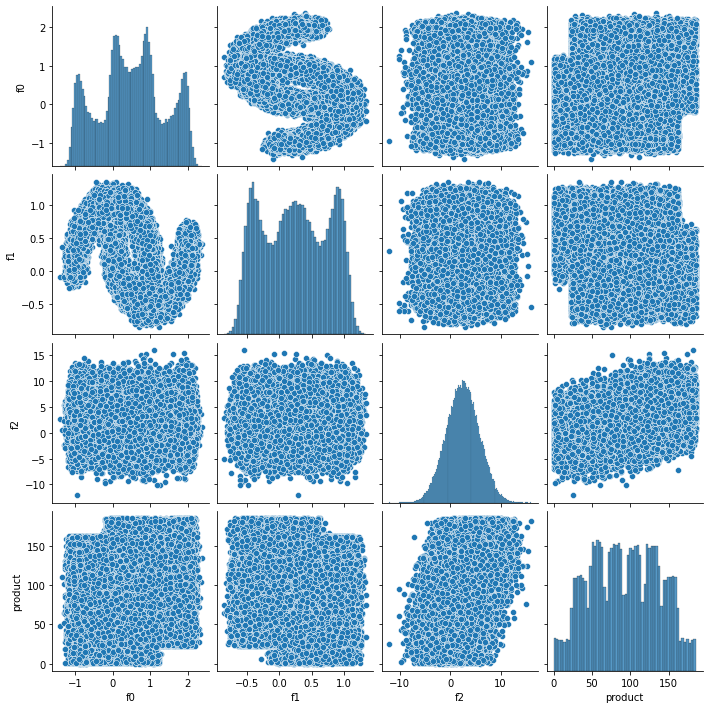

In [6]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(df1.corr(method='spearman'), annot=True, cmap='coolwarm', center=0)
sns.pairplot(df1)

Наблюдается умеренная зависимость целевого параметра `product` от признака `f2`, мультиколлинеарность и утечка отсутствует.

---

#### Второй датафрейм:

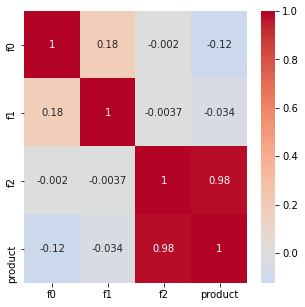

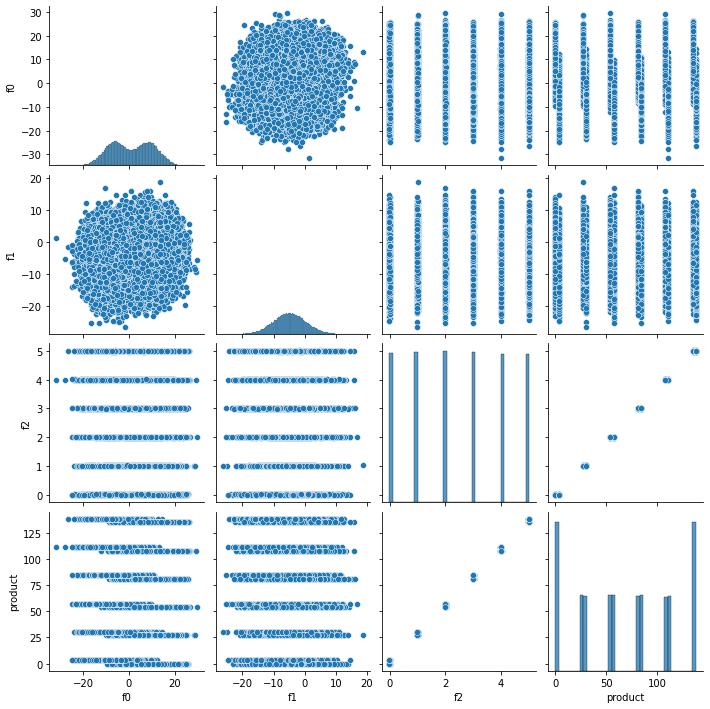

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(df2.corr(method='spearman'), annot=True, cmap='coolwarm', center=0)
sns.pairplot(df2)

Наблюдается **сильная зависимость** целевого параметра `product` от признака `f2`: возможно, имеет место утечка в данных. Мультиколлинеарность отсутствует.

---

#### Третий датафрейм:

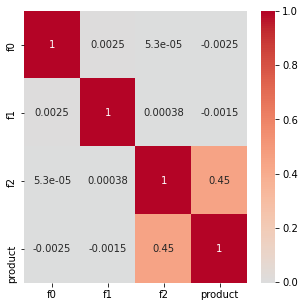

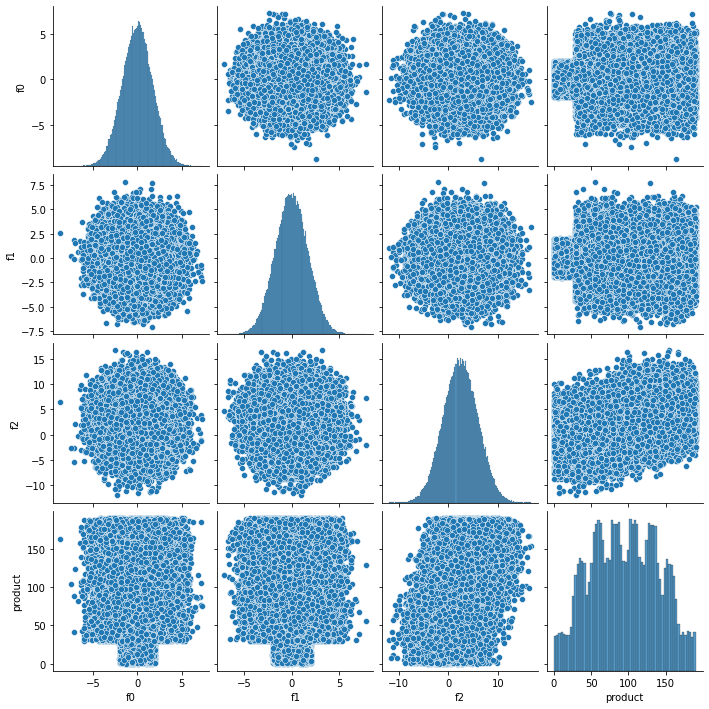

In [8]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(df3.corr(method='spearman'), annot=True, cmap='coolwarm', center=0)
sns.pairplot(df3)

Наблюдается умеренная зависимость целевого параметра `product` от признака `f2`, мультиколлинеарность и утечка отсутствует.

#### Промежуточный вывод:

* первый датафрейм: наблюдается умеренная зависимость целевого параметра `product` от признака `f2`, мультиколлинеарность и утечка отсутствует;

* второй датафрейм: наблюдается **сильная зависимость** целевого параметра `product` от признака `f2`. Мультиколлинеарность отсутствует;

* третий датафрейм: Наблюдается умеренная зависимость целевого параметра `product` от признака `f2`, мультиколлинеарность и утечка отсутствует.

## Обучение и проверка модели

Обучим и проверим модель для каждого региона:
 * разобьём данные на обучающую и валидационную выборки в соотношении 75:25.
 
#### Функция для разбиения данных:

In [9]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
num_columns = ['f0', 'f1', 'f2']

def split(df):
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop('product', axis=1),
        df['product'],
        test_size = TEST_SIZE, 
        random_state = RANDOM_STATE,
    )
    return X_train, X_test, y_train, y_test


Подготовим метрику для оценки моделей:

In [10]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scorer = make_scorer(rmse, greater_is_better=False)

#### Обучение моделей

С помощью пайплайнов обучим три модели и проведём кросс-валидацию:

In [11]:
data_preprocessor = ColumnTransformer(
    [
        ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

pipe_final_linear_1 = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

pipe_final_linear_2 = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

pipe_final_linear_3 = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

X_train_1, X_test_1, y_train_1, y_test_1 = split(df1)
linear_1 = cross_val_score(pipe_final_linear_1, X_train_1, y_train_1, cv=5, scoring=scorer) 

print('Метрика RMSE линейной модели на кросс-валидации первого датасета:', - round(linear_1.mean(), 2))
print('Стандартное отклонение RMSE первого датасета:', round(np.std(linear_1), 2), '\n')

X_train_2, X_test_2, y_train_2, y_test_2 = split(df2)
linear_2 = cross_val_score(pipe_final_linear_2, X_train_2, y_train_2, cv=5, scoring=scorer) 

print('Метрика RMSE линейной модели на кросс-валидации второго датасета:', - round(linear_2.mean(), 2))
print('Стандартное отклонение RMSE второго датасета:', round(np.std(linear_2), 2), '\n')

X_train_3, X_test_3, y_train_3, y_test_3 = split(df3)
linear_3 = cross_val_score(pipe_final_linear_3, X_train_3, y_train_3, cv=5, scoring=scorer) 

print('Метрика RMSE линейной модели на кросс-валидации третьего датасета:', - round(linear_3.mean(), 2))
print('Стандартное отклонение RMSE третьего датасета:', round(np.std(linear_3), 2), '\n')

Метрика RMSE линейной модели на кросс-валидации первого датасета: 37.67
Стандартное отклонение RMSE первого датасета: 0.23 

Метрика RMSE линейной модели на кросс-валидации второго датасета: 0.89
Стандартное отклонение RMSE второго датасета: 0.0 

Метрика RMSE линейной модели на кросс-валидации третьего датасета: 40.03
Стандартное отклонение RMSE третьего датасета: 0.08 



#### Проверка моделей на тестовых выборках:

In [12]:
pipe_final_linear_1.fit(X_train_1, y_train_1)
y_pred_1 = pipe_final_linear_1.predict(X_test_1)

print(f'Метрика RMSE на тестовой выборке первого датасета: {round(rmse(y_test_1, y_pred_1), 2)}')
print(f'Средний запас предсказанного сырья по скважинам первого датасета, тыс.баррелей: {round(y_pred_1.mean(), 2)} \n')

pipe_final_linear_2.fit(X_train_2, y_train_2)
y_pred_2 = pipe_final_linear_2.predict(X_test_2)

print(f'Метрика RMSE на тестовой выборке второго датасета: {round(rmse(y_test_2, y_pred_2), 2)}')
print(f'Средний запас предсказанного сырья по скважинам второго датасета, тыс.баррелей: {round(y_pred_2.mean(), 2)} \n')

pipe_final_linear_3.fit(X_train_3, y_train_3)
y_pred_3 = pipe_final_linear_3.predict(X_test_3)

print(f'Метрика RMSE на тестовой выборке третьего датасета: {round(rmse(y_test_3, y_pred_3), 2)}')
print(f'Средний запас предсказанного сырья по скважинам третьего датасета, тыс.баррелей: {round(y_pred_3.mean(), 2)} \n')


Метрика RMSE на тестовой выборке первого датасета: 37.76
Средний запас предсказанного сырья по скважинам первого датасета, тыс.баррелей: 92.4 

Метрика RMSE на тестовой выборке второго датасета: 0.89
Средний запас предсказанного сырья по скважинам второго датасета, тыс.баррелей: 68.71 

Метрика RMSE на тестовой выборке третьего датасета: 40.15
Средний запас предсказанного сырья по скважинам третьего датасета, тыс.баррелей: 94.77 



#### Анализ остатков:

1 датафрейм:


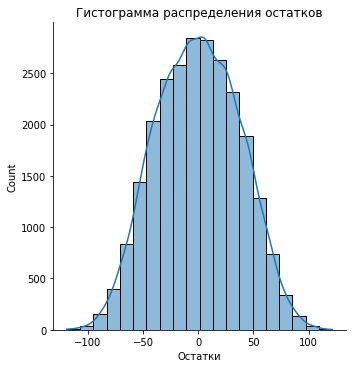

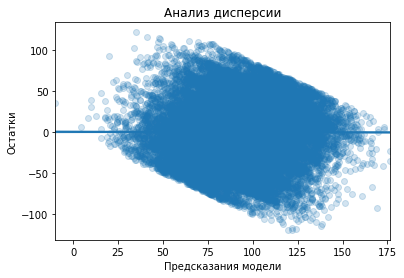


2 датафрейм:


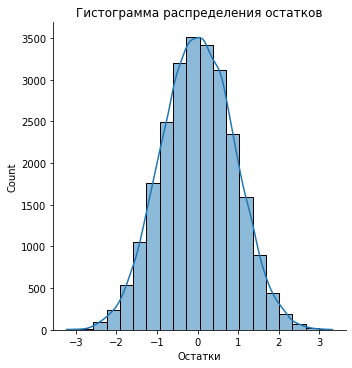

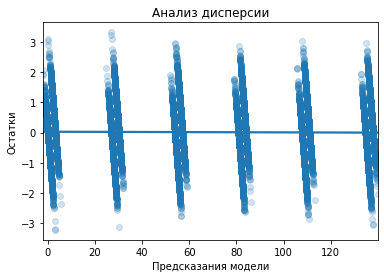


3 датафрейм:


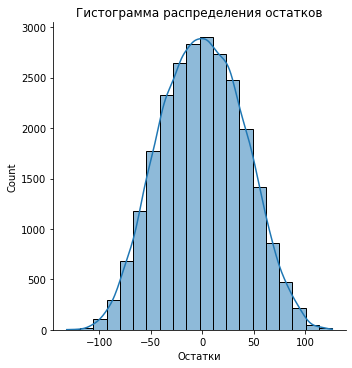

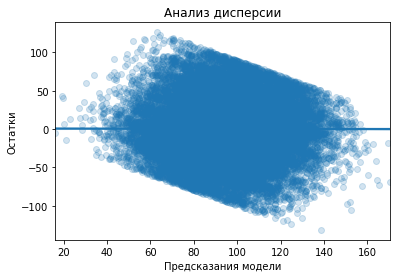

In [13]:
test = [y_test_1, y_test_2, y_test_3]
pred = [y_pred_1, y_pred_2, y_pred_3]

for i, value in enumerate(test):
    residuals = test[i] - pred[i]
    print(i+1, 'датафрейм:')
    
    sns.displot(residuals, kde=True, multiple='stack', bins=20)
    plt.title('Гистограмма распределения остатков')
    plt.xlabel('Остатки')
    plt.show()

    fig, ax = plt.subplots()
    sns.regplot(x=pred[i], y=residuals, fit_reg=True, scatter_kws={"alpha": 0.2})
    plt.xlabel('Предсказания модели')
    plt.ylabel('Остатки')
    plt.title('Анализ дисперсии')
    plt.show()
    
    print()

#### Промежуточный вывод:

Подготовлены и обучены три модели линейной регрессии. У первой и третьей моделей метрика MRSE и стандартное отклонение MRSE практически одинаковы (37,76 и 40,15 соответственно; 92,4 и 94,77 соответственно). Анализ остатков показывает нормальное распределение, однако **дисперия остатков не постоянна:** наблюдается отрицательная корреляция - чем больше предсказание модели, тем меньше значение остатка.

**По второму датафрейму подтверждается предположение об утечке данных:** значение вышеуказанных метрик ниже на порядок, модель чересчур точна. Максимальные значения распределения остатков ниже более чем в 30 раз. Рекомендуется проверка данных - возможно, параметр выгружен некорректно.

## Подготовка к расчёту прибыли

Все ключевые значения для расчётов сохранены в переменных `y_pred_1`, `y_pred_2`, `y_pred_3`.

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины и сравним полученные объёмы сырья со средним запасом по каждому региону. 

Условия задачи:

* Бюджет на разработку скважин в регионе — 10 млрд рублей;
* Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

In [14]:
BUDGET = pow(10, 10)
PROFIT_BARREL = 450_000
WELL_COUNT = 200

req_volume = BUDGET / (PROFIT_BARREL * WELL_COUNT)

print('Достаточный объём сырья для безубыточной разработки новой скважины:', round(req_volume, 2), 'тыс.барр \n')

print('Разница между средними запасами на скважину первого региона и объёмом сырья для безубыточной разработки:',\
      round(y_pred_1.mean() - req_volume, 2), 'тыс.барр')
print('Разница между средними запасами на скважину второго региона и объёмом сырья для безубыточной разработки:',\
      round(y_pred_2.mean() - req_volume, 2), 'тыс.барр')
print('Разница между средними запасами на скважину третьего региона и объёмом сырья для безубыточной рарзаботки:',\
      round(y_pred_3.mean() - req_volume, 2), 'тыс.барр')

Достаточный объём сырья для безубыточной разработки новой скважины: 111.11 тыс.барр 

Разница между средними запасами на скважину первого региона и объёмом сырья для безубыточной разработки: -18.71 тыс.барр
Разница между средними запасами на скважину второго региона и объёмом сырья для безубыточной разработки: -42.4 тыс.барр
Разница между средними запасами на скважину третьего региона и объёмом сырья для безубыточной рарзаботки: -16.34 тыс.барр


#### Промежуточный вывод:

Если ориентироваться исключительно на средние запасы по скважине, то **все три участка принесут убытки, т.к. запасов недостаточно.**

## Расчёт прибыли и рисков 

Составим  функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:

* выберем скважины с максимальными значениями предсказаний;
* просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям;
* рассчитаем прибыль для полученного объёма сырья.

In [15]:
def profit(X, y, target):
    y_pred = pd.concat([X, pd.Series(y, index=X.index)], axis=1)
    y_pred = y_pred.join(target)
    y_pred.rename(columns={0: 'pred', 'product': 'true'}, inplace=True)
    y_pred = y_pred[['pred', 'true']]
    return y_pred

In [16]:
y_pred_1_profit = profit(X_test_1, y_pred_1, y_test_1)
y_pred_2_profit = profit(X_test_2, y_pred_2, y_test_2)
y_pred_3_profit = profit(X_test_3, y_pred_3, y_test_3)

In [17]:
def revenue(target, count):
    probs_sorted = target.sort_values(by='pred', ascending=False)
    selected = target.loc[probs_sorted.index].iloc[0:count]
    return round(PROFIT_BARREL * selected['true'].sum() - BUDGET, 2)

### Расчёт прибыли по скважинам с максимальными запасами:

Рассчитаем прибыль по 200 лучшим скважинам по каждому региону:

In [18]:
print('Первый регион:', round(revenue(y_pred_1_profit, 200) / 10e8, 2), 'млрд руб.')

print('Второй регион:', round(revenue(y_pred_2_profit, 200) / 10e8, 2), 'млрд руб.')

print('Третий регион:', round(revenue(y_pred_3_profit, 200) / 10e8, 2), 'млрд руб.')


Первый регион: 3.36 млрд руб.
Второй регион: 2.42 млрд руб.
Третий регион: 2.6 млрд руб.


По лучшим скважинам лидирует первый регион (3,36 млрд руб.).

### Расчёт рисков и прибыли для каждого региона с помощью Bootstrap:
 
* число выборок - 1000;
* найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

In [19]:
def bootstrap(target):
    state = np.random.RandomState(12345)
    values = []
    for i in range(1000):
        target_subsample = target.sample(n=500, replace=True, random_state=state) 
        value = revenue(target_subsample, 200)  # Вычисляем значение выручки
        values.append(value)

    values = pd.Series(values)
        
    mean = values.mean()

    print("Средняя прибыль:", round(mean / 10e5, 2), 'млн руб.')
    
    print("Риск убытков:", round((values < 0).mean() * 100, 2), '%')
    
    lower_bound = values.quantile(0.025)  # 2.5%-квантиль
    upper_bound = values.quantile(0.975)  # 97.5%-квантиль

    print('95%-доверительный интервал для значения прибыли:')
    print('Нижняя граница:', lower_bound)
    print('Верхняя граница:', upper_bound, '\n')

    


In [20]:
print('Первый регион:')
bootstrap(y_pred_1_profit)
print('Второй регион:')
bootstrap(y_pred_2_profit)
print('Третий регион:')
bootstrap(y_pred_3_profit)

Первый регион:
Средняя прибыль: 435.93 млн руб.
Риск убытков: 6.1 %
95%-доверительный интервал для значения прибыли:
Нижняя граница: -116231612.77925
Верхняя граница: 966504180.7105 

Второй регион:
Средняя прибыль: 489.66 млн руб.
Риск убытков: 1.1 %
95%-доверительный интервал для значения прибыли:
Нижняя граница: 55116177.27575001
Верхняя граница: 905762650.42425 

Третий регион:
Средняя прибыль: 403.69 млн руб.
Риск убытков: 7.1 %
95%-доверительный интервал для значения прибыли:
Нижняя граница: -153116984.76599997
Верхняя граница: 952887416.7075 



#### Промежуточный вывод:

Расчёт с помощью Bootstrap показал, что наименее рисковым является второй регион.

## Итоговый вывод:

**Описание проекта:**

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

**Исходные данные:** в нашем распоряжении несколько датафреймов.

Данные геологоразведки по регионам находятся в трёх  файлах. 

    f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
    product — объём запасов в скважине (тыс. баррелей).

**Предобработка исходным датафреймам не требуется:** данные не имеют пропусков, дубликатов, неявных дубликатов.

**В ходе исследовательского анализа данных было сделано:**

* первый датафрейм: нормальное распределение наблюдается у параметра `f2`. По остальным параметрам также можно проследить нормальное распределение, но с несколькими локальными "пиками" данных;

* второй датафрейм: нормальное распределение наблюдается у параметра `f1`. По параметру `f0` также можно проследить нормальное распределение, но с несколькими локальными "пиками" данных. Параметры `f2` и `product` имеют "градацию" (практически все значения собраны в окрестности какого-либо значения, наблюдается интервальность);

* третий датафрейм: у параметра `product` можно проследить нормальное распределение, но с несколькими локальными "пиками" данных.  По остальным параметрам наблюдается нормальное распределение.

**Корреляционный анализ данных показал:**

* первый датафрейм: наблюдается умеренная зависимость целевого параметра `product` от признака `f2`, мультиколлинеарность и утечка отсутствует;

* второй датафрейм: наблюдается **сильная зависимость** целевого параметра `product` от признака `f2`. Мультиколлинеарность отсутствует;

* третий датафрейм: Наблюдается умеренная зависимость целевого параметра `product` от признака `f2`, мультиколлинеарность и утечка отсутствует.

**Подготовлены и обучены три модели линейной регрессии.** У первой и третьей моделей метрика MRSE и стандартное отклонение MRSE практически одинаковы (37,76 и 40,15 соответственно; 92,4 и 94,77 соответственно). Анализ остатков показывает нормальное распределение, однако **дисперия остатков не постоянна:** наблюдается отрицательная корреляция - чем больше предсказание модели, тем меньше значение остатка.

**По второму датафрейму можно сделть предположение об утечке данных:** значение вышеуказанных метрик ниже на порядок, модель чересчур точна. Максимальные значения распределения остатков ниже более чем в 30 раз. Рекомендуется проверка данных - возможно, параметр выгружен некорректно. *Необходимо дать аналитикам задачу исследовать данный параметр.*

Рассчитан достаточный объём сырья для безубыточной разработки новой скважины и сравнены полученные объёмы сырья со средним запасом по каждому региону. 
Если ориентироваться исключительно на средние запасы по скважине, то **все три участка принесут убытки, т.к. запасов недостаточно.**

Составлена функция для расчёта прибыли по выбранным скважинам и предсказаниям модели: *по лучшим скважинам лидирует первый регион (3,36 млрд руб.).*

Произведён расчёт рисков и прибыли для каждого региона с помощью Bootstrap: *наименее рисковым является второй регион:*

Его параметры:

* Средняя прибыль: 489.66 млн руб.
* Риск убытков: 1.1 %
* 95%-доверительный интервал для значения прибыли: (55116177.27575001, 905762650.42425).

Для разработки рекомендуется второй регион: средняя выручка не сильно отличается от других регионов, но риск убытков гораздо ниже.